# **Model Training:**



---



**Architectures:** In this notebook, we will be training 3 modern CNN architectures on the CAMELYON16 dataset. We will be training the last fully connected layer on a ResNet, DenseNet, and EfficientNet that have been pretrained on ImageNet.

**Data Pre-Processing:** Since the CAMELYON16 dataset contains WSIs that are gigapixel in resolution, we have preprocessed the data into 512x512 image patches. Because of storage and time constraints, we have opted to use about 65 WSIs, while the dataset contains roughly 230 WSIs. To make up for our lack of data, we are using data augmentation on the training data to diversify our sampling.

**Goals:** Our goal is to achieve 90% accuracy on all models as a baseline and applying GradCAM to our pipeline to explore model explainability.

**Reach Goals:** Given a new WSI, break the image into patches, run it through our prediction pipeline, and stitch together the GradCAM heatmaps to create a comprehensive image annotating where malignant cells exist.

In [ ]:
# === SANITY CHECK ===

# check file pathways and confirm number of normal/tumor patches

import os

normal_dir = "VisTumor/Training Data/Normal"
tumor_dir = "VisTumor/Training Data/Tumor"

# Count only files that are images (e.g., PNGs)
num_normal = len([f for f in os.listdir(normal_dir) if f.endswith('.png')])
num_tumor = len([f for f in os.listdir(tumor_dir) if f.endswith('.png')])
print(f"Number of normal images: {num_normal}")
print(f"Number of tumor images: {num_tumor}")

Number of normal images: 10960
Number of tumor images: 10595


In [ ]:
# installation to generate Grad-CAM heatmaps
!pip install torchcam matplotlib --quiet

In [ ]:
# import libraries
import os
import torch
import torch_directml
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [ ]:
# Connect to GPU
# Note: I ran a local runtime with an AMD GPU using DirectML on a Conda environment.
#       Mount google drive if you plan to connect to a Colab runtime or
#       connect to cuda if using an NVIDIA GPU
device = torch_directml.device()
print(device)

privateuseone:0


In [ ]:
# === RELOAD MODELS IF ALREADY TRAINED ===

# initialize ResNet model
resnet_model = models.resnet50(pretrained=False)
num_classes = 2
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

resnet_model.load_state_dict(torch.load('VisTumor/Models/ResNet/resnet50_camelyon16.pth'))
resnet_model = resnet_model.to(device)
resnet_model.eval()

In [ ]:
# reload loss dictionaries
resnet_training_loss = torch.load('VisTumor/Models/ResNet/resnet_training_loss.pt')
resnet_validation_loss = torch.load('VisTumor/Models/ResNet/resnet_validation_loss.pt')

In [ ]:
# initialize DenseNet model
densenet_model = models.densenet201(pretrained=False)
num_classes = 2
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, num_classes)

densenet_model.load_state_dict(torch.load('VisTumor/Models/DenseNet/densenet201_camelyon16.pth'))
densenet_model = densenet_model.to(device)
densenet_model.eval()

In [ ]:
# reload loss dictionaries
densenet_training_loss = torch.load('VisTumor/Models/DenseNet/densenet_training_loss.pt')
densenet_validation_loss = torch.load('VisTumor/Models/DenseNet/densenet_validation_loss.pt')

In [ ]:
# initialize EfficientNet model
efficientnet_model = models.efficientnet_b7(pretrained=False)
num_classes = 2
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, num_classes)

efficientnet_model.load_state_dict(torch.load('VisTumor/Models/EfficientNet/efficientnetb7_camelyon16.pth'))
efficientnet_model = efficientnet_model.to(device)
efficientnet_model.eval()

In [ ]:
efficientnet_training_loss = torch.load('VisTumor/Models/EfficientNet/efficientnet_training_loss.pt')
efficientnet_validation_loss = torch.load('VisTumor/Models/EfficientNet/efficientnet_validation_loss.pt')

# Data Pre-processing


---

Here, we will download, augment, and load our dataset.

In [ ]:
!pip install scikit-learn

In [ ]:
from torchvision.datasets import ImageFolder

class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        path, _ = self.samples[index]
        filename = os.path.basename(path)
        return image, label, filename

In [ ]:
# === DATA PRE-PROCESSING ===
train_path = "E:/493 Project/Training Data"

from torch.utils.data import RandomSampler
from sklearn.model_selection import train_test_split
import numpy as np
import torch_directml

# training augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# validation augmentation and normalization
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# load full dataset (no transform so we can split)
full_dataset = ImageFolderWithPaths(root=train_path)

indices = np.arange(len(full_dataset))
targets = np.array(full_dataset.targets)

# ensure our labels are balanced while splitting into train/validation
# current train/validation split: 90/10
train_idx, val_idx = train_test_split(
    indices, test_size=0.1, stratify=targets, random_state=42
)

# split data into a validation and training set
train_dataset = Subset(ImageFolderWithPaths(train_path, transform=train_transform), train_idx)
val_dataset = Subset(ImageFolderWithPaths(train_path, transform=val_transform), val_idx)

# load data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# === CHECK TRAIN/VALIDATION SPLIT ===
train_dataset_size = len(train_dataset)
val_dataset_size = len(val_dataset)

print(f"Train dataset size: {train_dataset_size}")
print(f"Validation dataset size: {val_dataset_size}")

Train dataset size: 19498
Validation dataset size: 2167


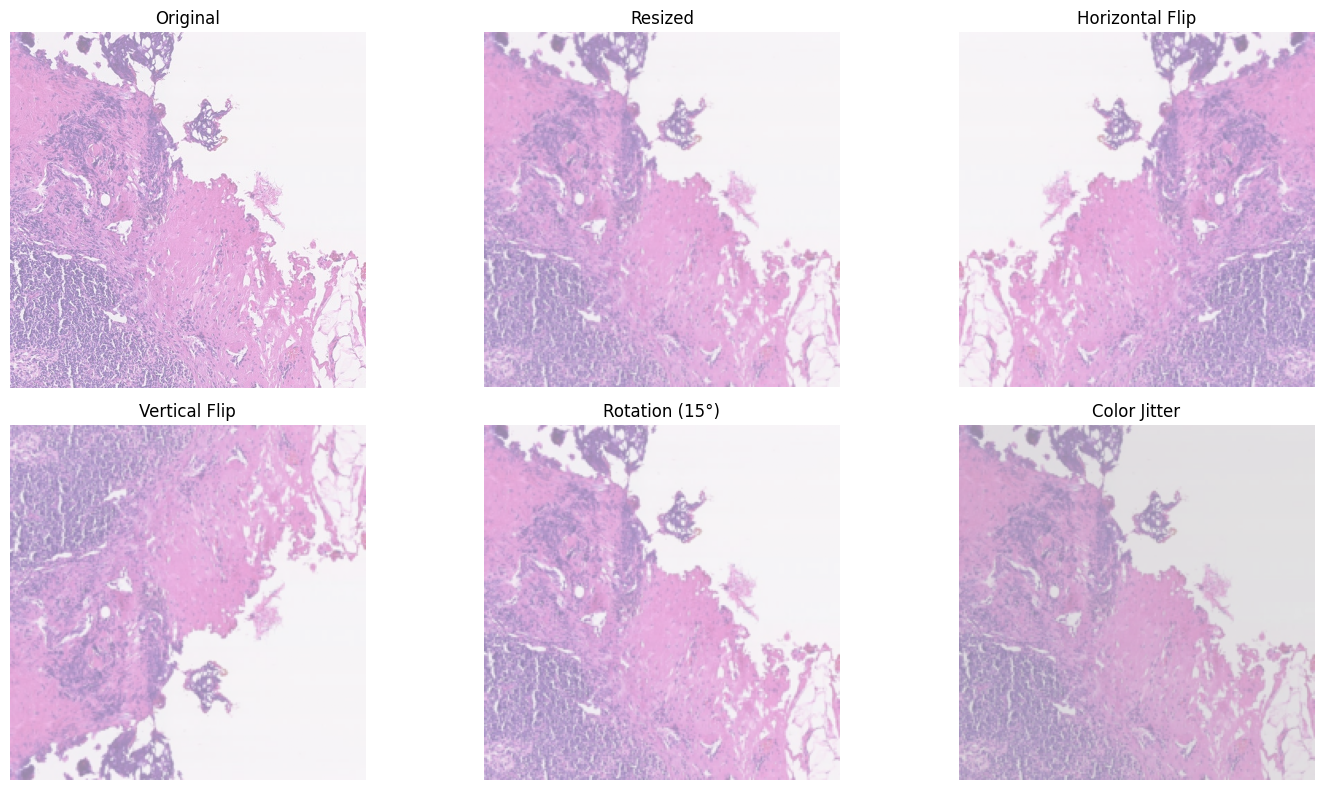

In [ ]:
# === DISPLAY AUGMENTATIONS ===

import random

# Load one sample image (change path/index as needed)
sample_image_path = train_dataset.dataset.samples[train_idx[0]][0]  # get image path from original index
image = Image.open(sample_image_path).convert("RGB")

# Define each augmentation individually
augmentations = {
    "Original": transforms.ToTensor(),
    "Resized": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "Horizontal Flip": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),  # force flip
        transforms.ToTensor()
    ]),
    "Vertical Flip": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomVerticalFlip(p=1.0),  # force flip
        transforms.ToTensor()
    ]),
    "Rotation (15°)": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(15),
        transforms.ToTensor()
    ]),
    "Color Jitter": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.ToTensor()
    ])
}

# Plot the results
plt.figure(figsize=(15, 8))

for i, (name, transform_fn) in enumerate(augmentations.items()):
    torch.manual_seed(0)  # to keep augmentation results consistent
    random.seed(0)

    transformed_image = transform_fn(image)
    np_img = transformed_image.permute(1, 2, 0).numpy()  # CHW to HWC
    np_img = (np_img * 0.5) + 0.5  # denormalize if normalized

    plt.subplot(2, 3, i + 1)
    plt.imshow(np.clip(np_img, 0, 1))
    plt.title(name)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Model Training


---

Here, we will train our 3 model architectures and find the validation accuracy for each.

In [ ]:
# === LOSS ARRAYS FOR PLOTTING ===
resnet_training_loss = []
resnet_validation_loss = []

densenet_training_loss = []
densenet_validation_loss = []

efficientnet_training_loss = []
efficientnet_validation_loss = []

In [ ]:
# === RESNET50 TRAINING ===

from tqdm import tqdm

# initialize pretrained model
resnet_model = models.resnet50(pretrained=True)

# freeze training in all layers
for param in resnet_model.parameters():
    param.requires_grad = False

# change final layer to match CAMELYON classification
num_classes = 2
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model = resnet_model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.fc.parameters(), lr=0.001)

# decide how long we want to train for
num_epochs = 5

# training
for epoch in range(num_epochs):

  resnet_model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

  for images, labels, _ in progress_bar:

    # move data to gpu
    images = images.to(device)
    labels = labels.to(device)

    # reset gradients to 0
    optimizer.zero_grad()

    outputs = resnet_model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)

    progress_bar.set_postfix({
      "Loss": f"{loss.item():.4f}",
      "Acc": f"{(correct/total):.4f}"
    })

  avg_loss = running_loss / len(train_loader)
  resnet_training_loss.append(avg_loss)
  accuracy = correct / total

  resnet_model.eval()
  running_val_loss = 0
  with torch.no_grad():
    for images, labels in val_loader:
      output = resnet_model(images.to(device))
      loss = criterion(output, labels.to(device))
      running_val_loss += loss.item()
  avg_val_loss = running_val_loss / len(val_loader)
  resnet_validation_loss.append(avg_val_loss)

  print(f"Epoch {epoch + 1}, Train Loss: {avg_loss}, Validation Loss = {avg_val_loss}, Accuracy: {accuracy}")

# save model to drive so we don't have to retrain just in case
torch.save(resnet_model.state_dict(), 'VisTumor/Models/ResNet/resnet50_camelyon16.pth')
torch.save(resnet_training_loss, 'VisTumor/Models/ResNet/resnet_training_loss.pt')
torch.save(resnet_validation_loss, 'VisTumor/Models/ResNet/resnet_validation_loss.pt')

In [ ]:
# === RESNET VALIDATION ===
from sklearn.metrics import confusion_matrix

resnet_model.eval()

# Track correct predictions and total samples
test_correct = 0
test_total = 0

all_preds = []
all_labels = []

# store examples for visualization
resnet_tp_example = None
resnet_fp_example = None
already_found_tp = False
already_found_fn = False

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels, filenames in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        # outputs
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs.data, 1)

        # accuracy
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        # false positives and negatives
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
          is_tp = (predicted[i] == 1 and labels[i] == 1)
          is_fn = (predicted[i] == 0 and labels[i] == 1)

          if is_tp and not already_found_tp:
            resnet_tp_example = (images[i].cpu(), labels[i].item(), filenames[i])
            already_found_tp = True

          if is_fn and not already_found_fn:
            resnet_fn_example = (images[i].cpu(), labels[i].item(), filenames[i])
            already_found_fn = True

# Calculate and print test accuracy
test_accuracy = test_correct / test_total
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds, labels=[0,1]).ravel()

print(f"ResNet Test Accuracy: {test_accuracy:.4f}")
print(f"False Positive Rate: {fp / (fp + tn):.4f}")
print(f"False Negative Rate: {fn / (fn + tp):.4f}")
print(f"Precision: {tp / (tp + fp):.4f}")
print(f"Recall: {tp / (tp + fn):.4f}")
print(resnet_tp_example[2])
print(resnet_fn_example[2])

ResNet Test Accuracy: 0.8316
False Positive Rate: 0.1615
False Negative Rate: 0.1670
Precision: 0.8330
Recall: 0.8330
tumor_110_6656_3840.png
tumor_110_6400_4480.png


In [ ]:
# === DENSENET201 TRAINING ===

from tqdm import tqdm

# initialize pretrained model
densenet_model = models.densenet201(pretrained=True)

# freeze training in all layers
for param in densenet_model.parameters():
    param.requires_grad = False

# change final layer
num_classes = 2
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, num_classes)
densenet_model = densenet_model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet_model.classifier.parameters(), lr=0.001)

# decide how long we want to train for
num_epochs = 5

# training
for epoch in range(num_epochs):
  densenet_model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

  for images, labels, _ in progress_bar:

    # move data to gpu
    images = images.to(device)
    labels = labels.to(device)

    # reset gradients to 0
    optimizer.zero_grad()

    outputs = densenet_model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)

    progress_bar.set_postfix({
      "Loss": f"{loss.item():.4f}",
      "Acc": f"{(correct/total):.4f}"
    })

  avg_loss = running_loss / len(train_loader)
  densenet_training_loss.append(avg_loss)
  accuracy = correct / total

  densenet_model.eval()
  running_val_loss = 0
  with torch.no_grad():
    for images, labels in val_loader:
      output = densenet_model(images.to(device))
      loss = criterion(output, labels.to(device))
      running_val_loss += loss.item()
  avg_val_loss = running_val_loss / len(val_loader)
  densenet_validation_loss.append(avg_val_loss)

  print(f"Epoch {epoch + 1}, Train Loss: {avg_loss}, Validation Loss = {avg_val_loss}, Accuracy: {accuracy}")

# save model to drive so we don't have to retrain just in case
torch.save(densenet_model.state_dict(), 'VisTumor/Models/DenseNet/densenet201_camelyon16.pth')
torch.save(densenet_training_loss, 'VisTumor/Models/DenseNet/densenet_training_loss.pt')
torch.save(densenet_validation_loss, 'VisTumor/Models/DenseNet/densenet_validation_loss.pt')

Epoch 1/5: 100%|████████████████████████████████████████████| 607/607 [04:32<00:00,  2.23it/s, Loss=0.8625, Acc=0.7979]


Epoch 1, Train Loss: 0.43423997334632686, Validation Loss = 0.34965306892991066, Accuracy: 0.797876179184494


Epoch 2/5: 100%|████████████████████████████████████████████| 607/607 [04:32<00:00,  2.23it/s, Loss=0.4003, Acc=0.8268]


Epoch 2, Train Loss: 0.3836184585654166, Validation Loss = 0.3346281380337827, Accuracy: 0.8267951956286407


Epoch 3/5: 100%|████████████████████████████████████████████| 607/607 [04:38<00:00,  2.18it/s, Loss=0.1844, Acc=0.8281]


Epoch 3, Train Loss: 0.3766249814231863, Validation Loss = 0.3322690348414814, Accuracy: 0.8280839218516418


Epoch 4/5: 100%|████████████████████████████████████████████| 607/607 [04:37<00:00,  2.18it/s, Loss=0.5403, Acc=0.8382]


Epoch 4, Train Loss: 0.36748369477529697, Validation Loss = 0.32771237260278535, Accuracy: 0.8382390844888912


Epoch 5/5: 100%|████████████████████████████████████████████| 607/607 [04:38<00:00,  2.18it/s, Loss=0.7912, Acc=0.8326]


Epoch 5, Train Loss: 0.37119327551843306, Validation Loss = 0.3244258728535736, Accuracy: 0.832620238156606


In [ ]:
# === DENSENET VALIDATION ===

from sklearn.metrics import confusion_matrix

densenet_model.eval()

# Track correct predictions and total samples
test_correct = 0
test_total = 0

all_preds = []
all_labels = []

# store examples for visualization
densenet_tp_example = None
densenet_fp_example = None
already_found_tp = False
already_found_fn = False

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels, filenames in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = densenet_model(images)
        _, predicted = torch.max(outputs.data, 1)

        # test accuracy
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        # false positives and negatives
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
          is_tp = (predicted[i] == 1 and labels[i] == 1)
          is_fn = (predicted[i] == 0 and labels[i] == 1)

          if is_tp and not already_found_tp:
            densenet_tp_example = (images[i].cpu(), labels[i].item(), filenames[i])
            already_found_tp = True

          if is_fn and not already_found_fn:
            densenet_fn_example = (images[i].cpu(), labels[i].item(), filenames[i])
            already_found_fn = True

# Calculate and print test accuracy
test_accuracy = test_correct / test_total
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds, labels=[0, 1]).ravel()

print(f"DenseNet Test Accuracy: {test_accuracy:.4f}")
print(f"False Positive Rate: {fp / (fp + tn):.4f}")
print(f"False Negative Rate: {fn / (fn + tp):.4f}")
print(f"Precision: {tp / (tp + fp):.4f}")
print(f"Recall: {tp / (tp + fn):.4f}")
print(densenet_fn_example[2])

DenseNet Test Accuracy: 0.8588
False Positive Rate: 0.1569
False Negative Rate: 0.1160
Precision: 0.8449
Recall: 0.8840
tumor_055_7296_18176.png


In [ ]:
# === EFFICIENTNETB7 TRAINING ===

from tqdm import tqdm

# initialize pretrained model
efficientnet_model = models.efficientnet_b7(pretrained=True)

# freeze training in all layers
for param in efficientnet_model.parameters():
    param.requires_grad = False

# change final layer
num_classes = 2
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, num_classes)
efficientnet_model = efficientnet_model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet_model.classifier[1].parameters(), lr=0.001)

# decide how long we want to train for
num_epochs = 5

# training
for epoch in range(num_epochs):
  efficientnet_model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

  for images, labels in progress_bar:

    # move data to gpu
    images = images.to(device)
    labels = labels.to(device)

    # reset gradients to 0
    optimizer.zero_grad()

    outputs = efficientnet_model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)

    progress_bar.set_postfix({
      "Loss": f"{loss.item():.4f}",
      "Acc": f"{(correct/total):.4f}"
    })

  avg_loss = running_loss / len(train_loader)
  efficientnet_training_loss.append(avg_loss)
  accuracy = correct / total

  efficientnet_model.eval()
  running_val_loss = 0
  with torch.no_grad():
    for images, labels in val_loader:
      output = efficientnet_model(images.to(device))
      loss = criterion(output, labels.to(device))
      running_val_loss += loss.item()
  avg_val_loss = running_val_loss / len(val_loader)
  efficientnet_validation_loss.append(avg_val_loss)

  print(f"Epoch {epoch + 1}, Train Loss: {avg_loss}, Validation Loss = {avg_val_loss}, Accuracy: {accuracy}")

# save model to drive so we don't have to retrain just in case
torch.save(efficientnet_model.state_dict(), 'VisTumor/Models/EfficientNet/efficientnetb7_camelyon16.pth')
torch.save(efficientnet_training_loss, 'VisTumor/Models/EfficientNet/efficientnet_training_loss.pt')
torch.save(efficientnet_validation_loss, 'VisTumor/Models/EfficientNet/efficientnet_validation_loss.pt')

Epoch 1/5: 100%|████████████████████████████████████████████| 607/607 [05:19<00:00,  1.90it/s, Loss=0.7324, Acc=0.7360]


Epoch 1, Train Loss: 0.5282587211155616, Validation Loss = 0.4774291370721424, Accuracy: 0.7359657714315171


Epoch 2/5: 100%|████████████████████████████████████████████| 607/607 [05:22<00:00,  1.88it/s, Loss=0.9770, Acc=0.7532]


Epoch 2, Train Loss: 0.5103351349100054, Validation Loss = 0.46308306473142963, Accuracy: 0.7531831537708129


Epoch 3/5: 100%|████████████████████████████████████████████| 607/607 [05:21<00:00,  1.89it/s, Loss=0.2474, Acc=0.7549]


Epoch 3, Train Loss: 0.5039209687140275, Validation Loss = 0.45304419582380967, Accuracy: 0.7548842723851745


Epoch 4/5: 100%|████████████████████████████████████████████| 607/607 [05:20<00:00,  1.89it/s, Loss=0.2213, Acc=0.7522]


Epoch 4, Train Loss: 0.5079189161148653, Validation Loss = 0.4559026426252197, Accuracy: 0.752152172792412


Epoch 5/5: 100%|████████████████████████████████████████████| 607/607 [05:20<00:00,  1.89it/s, Loss=0.8295, Acc=0.7472]


Epoch 5, Train Loss: 0.5161260844160737, Validation Loss = 0.4350050687789917, Accuracy: 0.7471519150471674


In [ ]:
# === EFFICIENTNET VALIDATION ===

from sklearn.metrics import confusion_matrix

efficientnet_model.eval()

# Track correct predictions and total samples
test_correct = 0
test_total = 0

all_preds = []
all_labels = []

# store examples for visualization
efficientnet_tp_example = None
efficientnet_fp_example = None
already_found_tp = False
already_found_fn = False

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels, filenames in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = efficientnet_model(images)
        _, predicted = torch.max(outputs.data, 1)

        # test accuracy
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        for i in range(len(labels)):
          is_tp = (predicted[i] == 1 and labels[i] == 1)
          is_fn = (predicted[i] == 0 and labels[i] == 1)

          if is_tp and not already_found_tp:
            efficientnet_tp_example = (images[i].cpu(), labels[i].item(), filenames[i])
            already_found_tp = True

          if is_fn and not already_found_fn:
            efficientnet_fn_example = (images[i].cpu(), labels[i].item(), filenames[i])
            already_found_fn = True

# Calculate and print test accuracy
test_accuracy = test_correct / test_total
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds, labels=[0, 1]).ravel()

print(f"EfficientNet Test Accuracy: {test_accuracy:.4f}")
print(f"False Positive Rate: {fp / (fp + tn):.4f}")
print(f"False Negative Rate: {fn / (fn + tp):.4f}")
print(f"Precision: {tp / (tp + fp):.4f}")
print(f"Recall: {tp / (tp + fn):.4f}")
print(efficientnet_fn_example[2])

EfficientNet Test Accuracy: 0.8039
False Positive Rate: 0.1168
False Negative Rate: 0.2698
Precision: 0.8581
Recall: 0.7302
tumor_110_6656_3840.png


# Grad-CAM + Performance


---

In this section, we will be adding Grad-CAM to our pipeline and comparing heatmaps and performance across our models.

In [ ]:
!pip install grad-cam

In [ ]:
# === GRADCAM FUNCTIONS ===

import torch
import torchvision.models
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Detect model type and return the correct last convolutional block for Grad-CAM
def get_target_layer(model):
  if isinstance(model, torchvision.models.ResNet):
    return model.layer4[-1]
  elif isinstance(model, torchvision.models.DenseNet):
    return model.features[-1]
  elif isinstance(model, torchvision.models.EfficientNet):
    return model.features[-2]

# load an annotation patch
def load_annotation(patch_filename, annotation_root, patch_size=512):
  SCALE_FACTOR = 0.25

  name_parts = patch_filename.replace(".png", "").split("_")
  slide_id = name_parts[1]
  x = int(name_parts[2])
  y = int(name_parts[3])

  mask_path = os.path.join(annotation_root, f"tumor_{slide_id}_evaluation_mask.png")
  if not os.path.exists(mask_path):
    print(f"Mask not found for {patch_filename}")
    return np.zeros((patch_size, patch_size), dtype=np.uint8)

  annotation_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  annotation_mask = (annotation_mask > 0).astype(np.uint8)

  ax = int(x * SCALE_FACTOR)
  ay = int(y * SCALE_FACTOR)
  aw = int(patch_size * SCALE_FACTOR)
  ah = int(patch_size * SCALE_FACTOR)

  crop = annotation_mask[ay:ay + ah, ax:ax + aw]

  resized = cv2.resize(crop, (224, 224), interpolation=cv2.INTER_NEAREST)
  return resized

# Grad-CAM visualization function
def apply_gradcam(model, image_tensor):
    image = image_tensor.unsqueeze(0).to(device)
    image.requires_grad_()

    model.eval()

    target_layer = get_target_layer(model)
    activations = None

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    hook = target_layer.register_forward_hook(forward_hook)

    output = model(image)
    hook.remove()

    pred_class = output.argmax(dim=1).item()
    score = output[0, pred_class]

    grads = torch.autograd.grad(score, activations, retain_graph=True)[0]
    pooled_gradients = torch.mean(grads, dim=[0, 2, 3])

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap -= heatmap.min()
    heatmap /= heatmap.max() + 1e-8
    heatmap = heatmap.cpu().detach().numpy()

    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-8)

    heatmap_resized = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = np.float32(heatmap_colored) / 255

    overlay = heatmap_colored * 0.25 + image_np
    overlay = np.clip(overlay, 0, 1)

    return image_np, heatmap_resized, overlay

# Grad-CAM++ visualization function
def apply_gradcam_plusplus(model, image_tensor):
    model.eval()

    device = next(model.parameters()).device
    input_tensor = image_tensor.unsqueeze(0).to(device)
    input_tensor.requires_grad_()  # 🔧 Make sure gradients can be tracked!

    # Prepare RGB image for visualization
    rgb_image = image_tensor.permute(1, 2, 0).cpu().numpy()
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min() + 1e-8)

    # Get correct layer for Grad-CAM++
    target_layer = get_target_layer(model)

    # Initialize GradCAM++
    cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

    # Explicit target category
    with torch.no_grad():
        pred_class = torch.argmax(model(input_tensor)).item()
    targets = [ClassifierOutputTarget(pred_class)]

    # Apply Grad-CAM++
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Overlay
    overlay = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True, image_weight=0.75)

    return rgb_image, grayscale_cam, overlay

# SmoothGrad visualization function
def apply_smoothgrad(model, image_tensor, target_class=None, num_samples=25, noise_level=0.15, device=None):
    model.eval()

    if device is None:
      device = next(model.parameters()).device

    image_tensor = image_tensor.to(device)  # Ensure image is on same device
    input_tensor = image_tensor.unsqueeze(0).clone().detach()
    input_tensor.requires_grad = True

    if target_class is None:
        with torch.no_grad():
            output = model(input_tensor)
            target_class = output.argmax(dim=1).item()

    saliency_sum = torch.zeros_like(image_tensor).to(device)

    for _ in range(num_samples):
        noise = torch.randn_like(image_tensor).to(device) * noise_level
        noisy_input = (image_tensor + noise).unsqueeze(0)
        noisy_input.requires_grad_()

        output = model(noisy_input)
        loss = output[0, target_class]

        model.zero_grad()
        loss.backward()

        grad = noisy_input.grad.data.squeeze()
        saliency_sum += grad.abs()

    smooth_grad = saliency_sum / num_samples

    # Normalize
    smooth_grad -= smooth_grad.min()
    smooth_grad /= (smooth_grad.max() + 1e-8)
    smooth_grad = smooth_grad.cpu().numpy()

    # Convert to (H, W, C)
    original_image = image_tensor.permute(1, 2, 0).detach().cpu().numpy()
    original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min() + 1e-8)

    if smooth_grad.shape[0] == 3:
        smooth_grad_map = np.mean(smooth_grad, axis=0)
    else:
        smooth_grad_map = smooth_grad

    return original_image, smooth_grad_map, show_cam_on_image(original_image, smooth_grad_map, use_rgb=True, image_weight = 0.75)

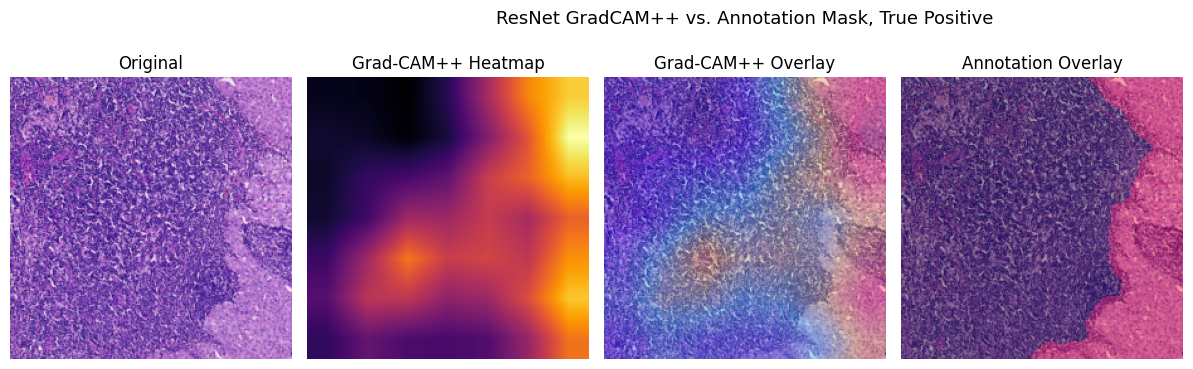

In [ ]:
# === RESNET TRUE POSITIVE GRADCAM++/ANNOTATION COMPARISON ===

patch_path = os.path.join(r"VisTumor\Training Data\Tumor", resnet_tp_example[2])
annotation_path = r"VisTumor\Training Data\evaluation_masks"

patch = Image.open(patch_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_tensor = transform(patch)

original, heatmap, overlay = apply_gradcam_plusplus(resnet_model, img_tensor)

output = resnet_model(img_tensor.unsqueeze(0).to(device))
pred_class = output.argmax(dim=1).item()

# Convert to readable labels
correctness = "True Positive"

patch_filename = os.path.basename(patch_path)
annotation_mask = load_annotation(patch_filename, annotation_path)

annotation_rgb = np.stack([annotation_mask, np.zeros_like(annotation_mask), np.zeros_like(annotation_mask)], axis=-1)
annotation_rgb = annotation_rgb.astype(np.float32)
annotation_rgb /= annotation_rgb.max() if annotation_rgb.max() > 0 else 1

# Normalize original patch
original_norm = (original - original.min()) / (original.max() - original.min() + 1e-8)

# Create overlay: 70% original + 30% red annotation
sanity_overlay = 0.7 * original_norm + 0.3 * annotation_rgb
sanity_overlay = np.clip(sanity_overlay, 0, 1)

# Plot all results
plt.figure(figsize=(15, 4))
plt.suptitle(f"ResNet GradCAM++ vs. Annotation Mask, {correctness}", fontsize=13)

plt.subplot(1, 5, 1)
plt.imshow(original)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(heatmap, cmap="inferno")
plt.title("Grad-CAM++ Heatmap")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(overlay)
plt.title("Grad-CAM++ Overlay")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(sanity_overlay)
plt.title("Annotation Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

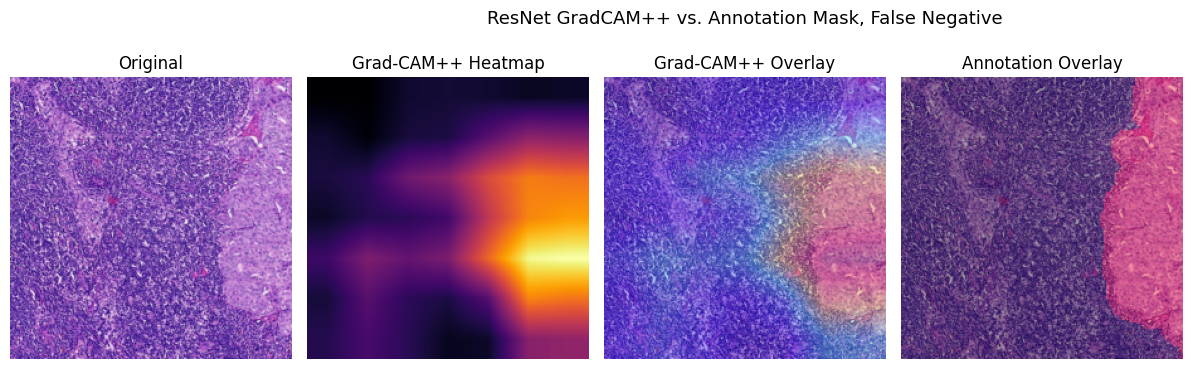

In [ ]:
# === RESNET FALSE NEGATIVE GRADCAM++/ANNOTATION COMPARISON ===

patch_path = os.path.join(r"VisTumor\Training Data\Tumor", resnet_fn_example[2])
annotation_path = r"VisTumor\Training Data\evaluation_masks"

patch = Image.open(patch_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_tensor = transform(patch)

original, heatmap, overlay = apply_gradcam_plusplus(resnet_model, img_tensor)

output = resnet_model(img_tensor.unsqueeze(0).to(device))
pred_class = output.argmax(dim=1).item()

# Convert to readable labels
correctness = "False Negative"

patch_filename = os.path.basename(patch_path)
annotation_mask = load_annotation(patch_filename, annotation_path)

annotation_rgb = np.stack([annotation_mask, np.zeros_like(annotation_mask), np.zeros_like(annotation_mask)], axis=-1)
annotation_rgb = annotation_rgb.astype(np.float32)
annotation_rgb /= annotation_rgb.max() if annotation_rgb.max() > 0 else 1

# Normalize original patch
original_norm = (original - original.min()) / (original.max() - original.min() + 1e-8)

# Create overlay: 70% original + 30% red annotation
sanity_overlay = 0.7 * original_norm + 0.3 * annotation_rgb
sanity_overlay = np.clip(sanity_overlay, 0, 1)

# Plot all results
plt.figure(figsize=(15, 4))
plt.suptitle(f"ResNet GradCAM++ vs. Annotation Mask, {correctness}", fontsize=13)

plt.subplot(1, 5, 1)
plt.imshow(original)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(heatmap, cmap="inferno")
plt.title("Grad-CAM++ Heatmap")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(overlay)
plt.title("Grad-CAM++ Overlay")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(sanity_overlay)
plt.title("Annotation Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

<Figure size 1200x300 with 0 Axes>

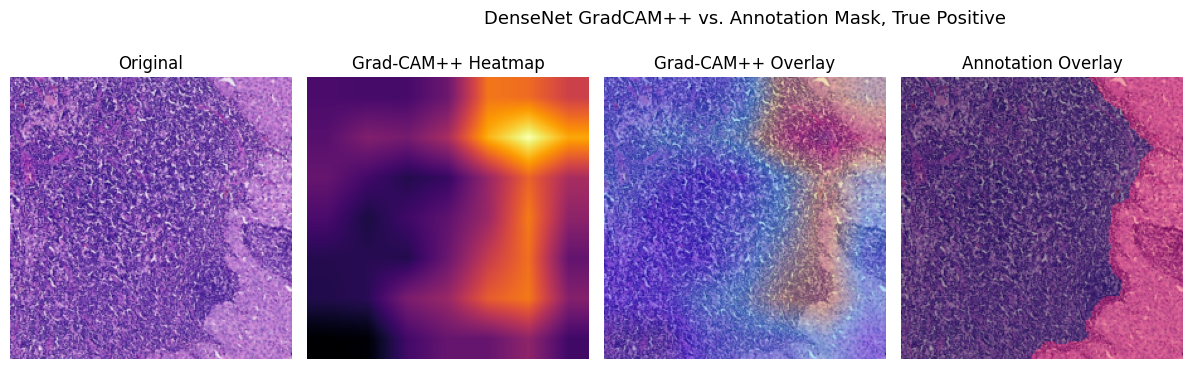

In [ ]:
# === DENSENET TRUE POSITIVE GRADCAM++/ANNOTATION COMPARISON ===

patch_path = os.path.join(r"VisTumor\Training Data\Tumor", densenet_tp_example[2])
annotation_path = r"VisTumor\Training Data\evaluation_masks"

patch = Image.open(patch_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_tensor = transform(patch)

original, heatmap, overlay = apply_gradcam_plusplus(densenet_model, img_tensor)

output = densenet_model(img_tensor.unsqueeze(0).to(device))
pred_class = output.argmax(dim=1).item()

# Convert to readable labels
correctness = "True Positive"

patch_filename = os.path.basename(patch_path)
annotation_mask = load_annotation(patch_filename, annotation_path)

annotation_rgb = np.stack([annotation_mask, np.zeros_like(annotation_mask), np.zeros_like(annotation_mask)], axis=-1)
annotation_rgb = annotation_rgb.astype(np.float32)
annotation_rgb /= annotation_rgb.max() if annotation_rgb.max() > 0 else 1

# Normalize original patch
original_norm = (original - original.min()) / (original.max() - original.min() + 1e-8)

# Create overlay: 70% original + 30% red annotation
sanity_overlay = 0.7 * original_norm + 0.3 * annotation_rgb
sanity_overlay = np.clip(sanity_overlay, 0, 1)

# Plot results
plt.figure(figsize=(12, 3))
plt.suptitle(
  f"DenseNet GradCAM++ vs. Ground Truth Annotation",
  fontsize=13
)

# Plot all results
plt.figure(figsize=(15, 4))
plt.suptitle(f"DenseNet GradCAM++ vs. Annotation Mask, {correctness}", fontsize=13)

plt.subplot(1, 5, 1)
plt.imshow(original)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(heatmap, cmap="inferno")
plt.title("Grad-CAM++ Heatmap")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(overlay)
plt.title("Grad-CAM++ Overlay")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(sanity_overlay)
plt.title("Annotation Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

<Figure size 1200x300 with 0 Axes>

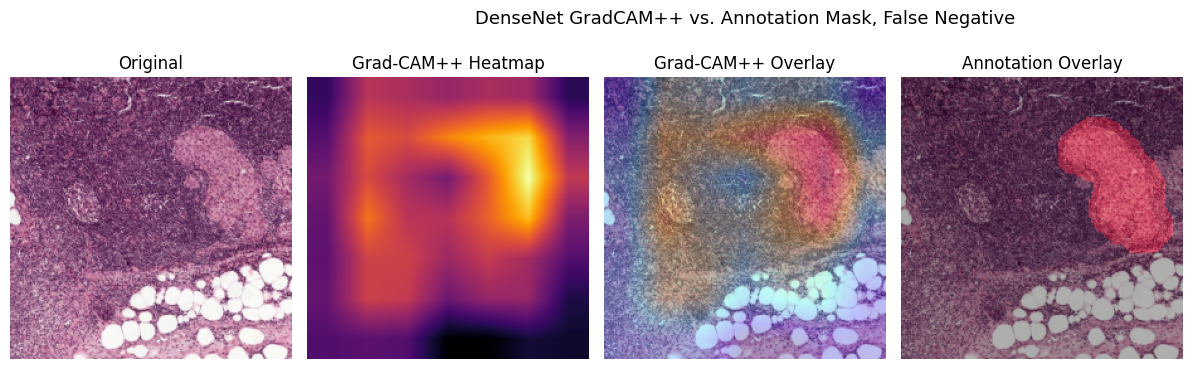

In [ ]:
# === DENSENET FALSE NEGATIVE GRADCAM++/ANNOTATION COMPARISON ===

patch_path = os.path.join(r"VisTumor\Training Data\Tumor", densenet_fn_example[2])
annotation_path = r"VisTumor\Training Data\evaluation_masks"

patch = Image.open(patch_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_tensor = transform(patch)

original, heatmap, overlay = apply_gradcam_plusplus(densenet_model, img_tensor)

output = densenet_model(img_tensor.unsqueeze(0).to(device))
pred_class = output.argmax(dim=1).item()

# Convert to readable labels
correctness = "False Negative"

patch_filename = os.path.basename(patch_path)
annotation_mask = load_annotation(patch_filename, annotation_path)

annotation_rgb = np.stack([annotation_mask, np.zeros_like(annotation_mask), np.zeros_like(annotation_mask)], axis=-1)
annotation_rgb = annotation_rgb.astype(np.float32)
annotation_rgb /= annotation_rgb.max() if annotation_rgb.max() > 0 else 1

# Normalize original patch
original_norm = (original - original.min()) / (original.max() - original.min() + 1e-8)

# Create overlay: 70% original + 30% red annotation
sanity_overlay = 0.7 * original_norm + 0.3 * annotation_rgb
sanity_overlay = np.clip(sanity_overlay, 0, 1)

# Plot results
plt.figure(figsize=(12, 3))
plt.suptitle(
  f"DenseNet GradCAM++ vs. Ground Truth Annotation",
  fontsize=13
)

# Plot all results
plt.figure(figsize=(15, 4))
plt.suptitle(f"DenseNet GradCAM++ vs. Annotation Mask, {correctness}", fontsize=13)

plt.subplot(1, 5, 1)
plt.imshow(original)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(heatmap, cmap="inferno")
plt.title("Grad-CAM++ Heatmap")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(overlay)
plt.title("Grad-CAM++ Overlay")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(sanity_overlay)
plt.title("Annotation Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

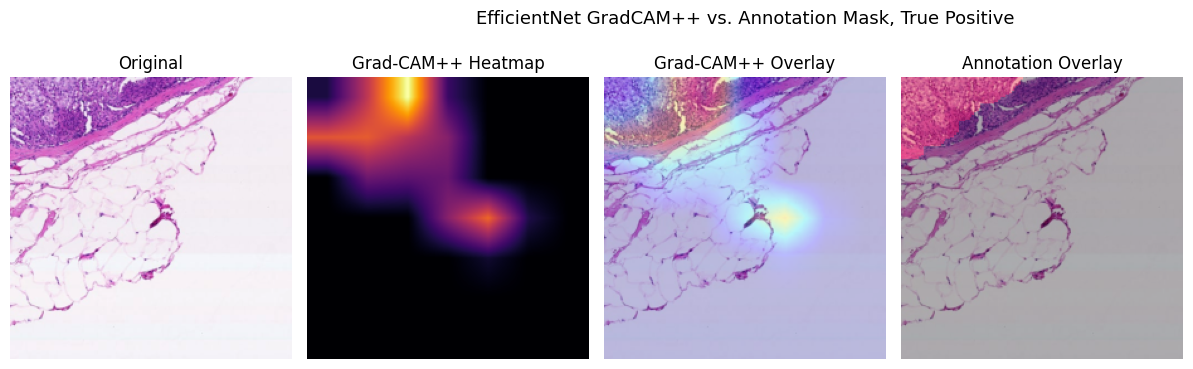

In [ ]:
# === EFFICIENTNET TRUE POSITIVE GRADCAM++/ANNOTATION COMPARISON ===

patch_path = os.path.join(r"VisTumor\Training Data\Tumor", efficientnet_tp_example[2])
annotation_path = r"VisTumor\Training Data\evaluation_masks"

patch = Image.open(patch_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_tensor = transform(patch)

original, heatmap, overlay = apply_gradcam_plusplus(efficientnet_model, img_tensor)
output = efficientnet_model(img_tensor.unsqueeze(0).to(device))
pred_class = output.argmax(dim=1).item()

# Convert to readable labels
correctness = "True Positive"

patch_filename = os.path.basename(patch_path)
annotation_mask = load_annotation(patch_filename, annotation_path)

annotation_rgb = np.stack([annotation_mask, np.zeros_like(annotation_mask), np.zeros_like(annotation_mask)], axis=-1)
annotation_rgb = annotation_rgb.astype(np.float32)
annotation_rgb /= annotation_rgb.max() if annotation_rgb.max() > 0 else 1

# Normalize original patch
original_norm = (original - original.min()) / (original.max() - original.min() + 1e-8)

# Create overlay: 70% original + 30% red annotation
sanity_overlay = 0.7 * original_norm + 0.3 * annotation_rgb
sanity_overlay = np.clip(sanity_overlay, 0, 1)

# Plot all results
plt.figure(figsize=(15, 4))
plt.suptitle(f"EfficientNet GradCAM++ vs. Annotation Mask, {correctness}", fontsize=13)

plt.subplot(1, 5, 1)
plt.imshow(original)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(heatmap, cmap="inferno")
plt.title("Grad-CAM++ Heatmap")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(overlay)
plt.title("Grad-CAM++ Overlay")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(sanity_overlay)
plt.title("Annotation Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

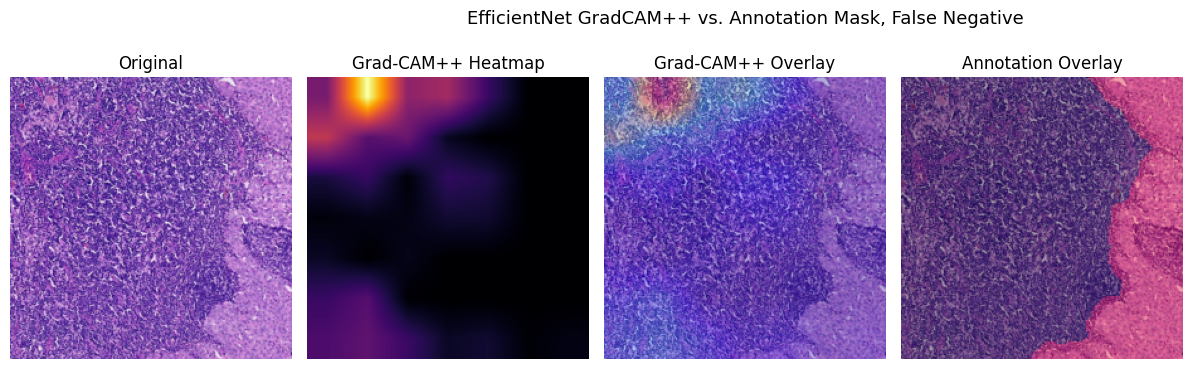

In [ ]:
# === EFFICIENTNET FALSE NEGATIVE GRADCAM++/ANNOTATION COMPARISON ===

patch_path = os.path.join(r"VisTumor\Training Data\Tumor", efficientnet_fn_example[2])
annotation_path = r"VisTumor\Training Data\evaluation_masks"

patch = Image.open(patch_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_tensor = transform(patch)

original, heatmap, overlay = apply_gradcam_plusplus(efficientnet_model, img_tensor)
output = efficientnet_model(img_tensor.unsqueeze(0).to(device))
pred_class = output.argmax(dim=1).item()

# Convert to readable labels
correctness = "False Negative"

patch_filename = os.path.basename(patch_path)
annotation_mask = load_annotation(patch_filename, annotation_path)

annotation_rgb = np.stack([annotation_mask, np.zeros_like(annotation_mask), np.zeros_like(annotation_mask)], axis=-1)
annotation_rgb = annotation_rgb.astype(np.float32)
annotation_rgb /= annotation_rgb.max() if annotation_rgb.max() > 0 else 1

# Normalize original patch
original_norm = (original - original.min()) / (original.max() - original.min() + 1e-8)

# Create overlay: 70% original + 30% red annotation
sanity_overlay = 0.7 * original_norm + 0.3 * annotation_rgb
sanity_overlay = np.clip(sanity_overlay, 0, 1)

# Plot all results
plt.figure(figsize=(15, 4))
plt.suptitle(f"EfficientNet GradCAM++ vs. Annotation Mask, {correctness}", fontsize=13)

plt.subplot(1, 5, 1)
plt.imshow(original)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(heatmap, cmap="inferno")
plt.title("Grad-CAM++ Heatmap")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(overlay)
plt.title("Grad-CAM++ Overlay")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(sanity_overlay)
plt.title("Annotation Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

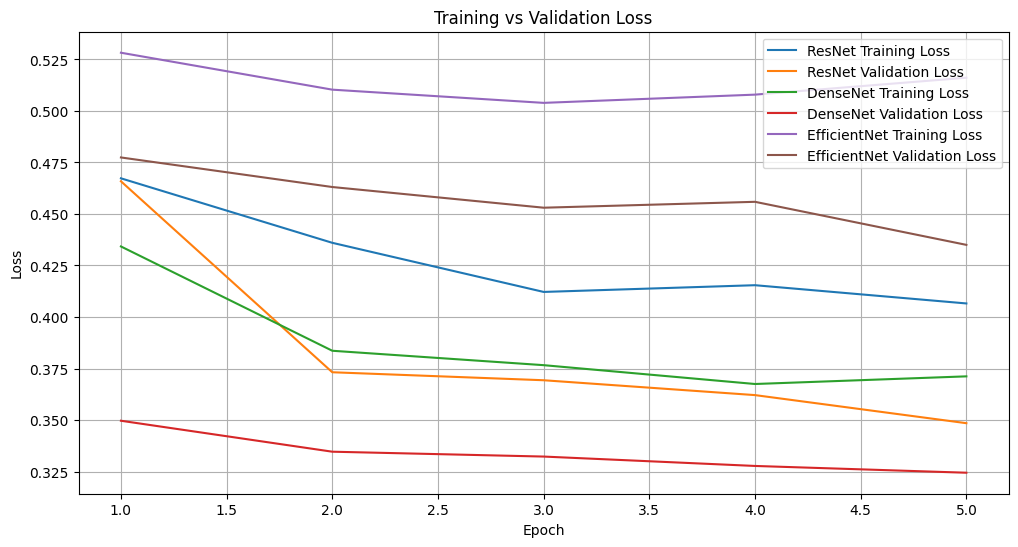

In [ ]:
# === PLOT LOSS CURVES ===

import matplotlib.pyplot as plt

epochs = range(1, len(resnet_training_loss) + 1)

plt.figure(figsize=(12, 6))

# ResNet
plt.plot(epochs, resnet_training_loss, label='ResNet Training Loss')
plt.plot(epochs, resnet_validation_loss, label='ResNet Validation Loss')

# DenseNet
plt.plot(epochs, densenet_training_loss, label='DenseNet Training Loss')
plt.plot(epochs, densenet_validation_loss, label='DenseNet Validation Loss')

# EfficientNet
plt.plot(epochs, efficientnet_training_loss, label='EfficientNet Training Loss')
plt.plot(epochs, efficientnet_validation_loss, label='EfficientNet Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

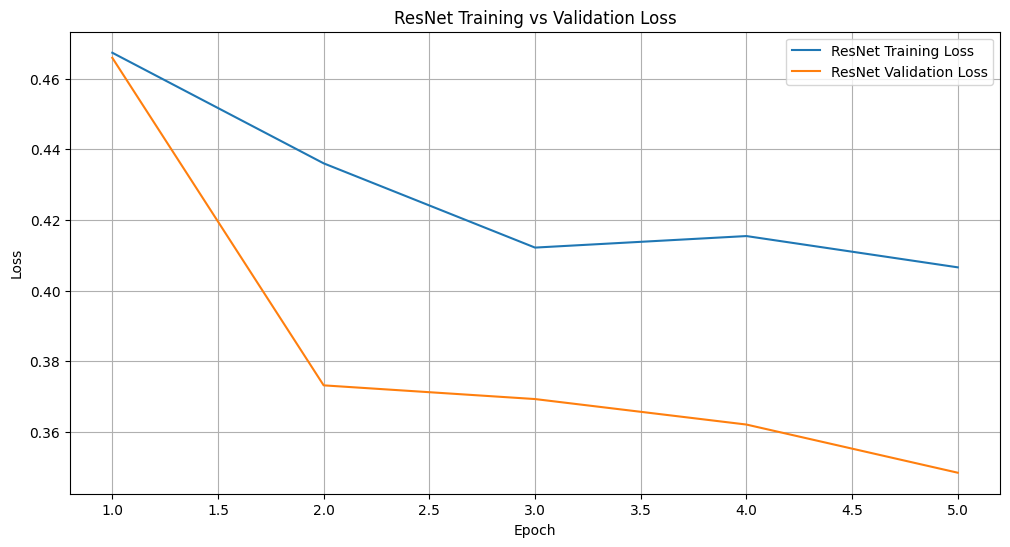

In [ ]:
# === PLOT RESNET CURVE ===

epochs = range(1, len(resnet_training_loss) + 1)

plt.figure(figsize=(12, 6))

# ResNet
plt.plot(epochs, resnet_training_loss, label='ResNet Training Loss')
plt.plot(epochs, resnet_validation_loss, label='ResNet Validation Loss')
plt.title('ResNet Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

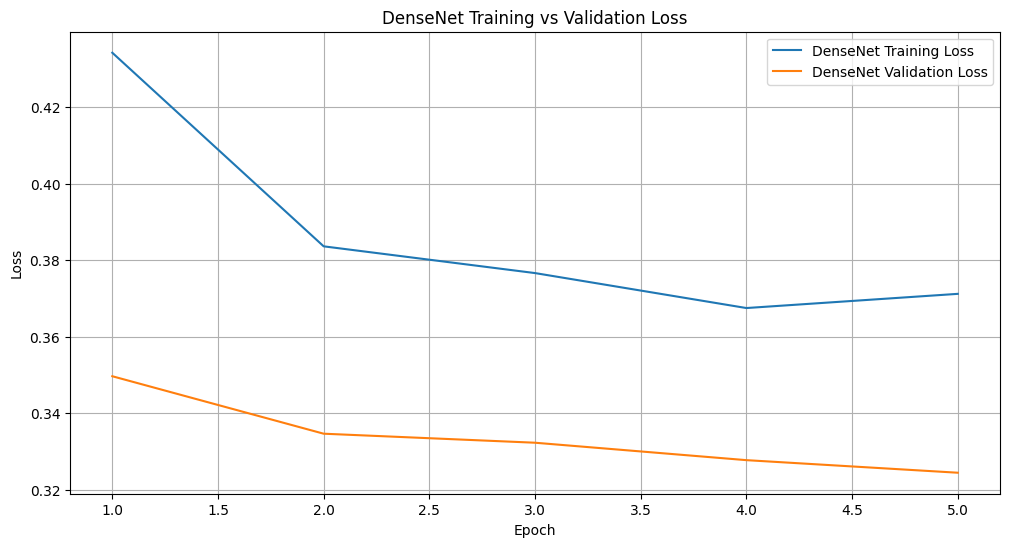

In [ ]:
# === PLOT DENSENET CURVE ===

epochs = range(1, len(resnet_training_loss) + 1)

plt.figure(figsize=(12, 6))

plt.plot(epochs, densenet_training_loss, label='DenseNet Training Loss')
plt.plot(epochs, densenet_validation_loss, label='DenseNet Validation Loss')
plt.title('DenseNet Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

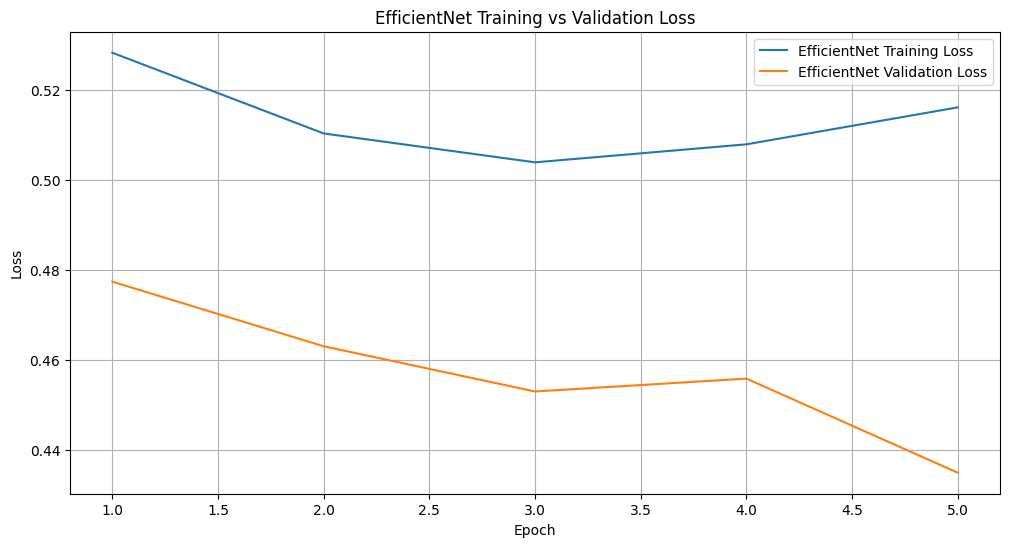

In [ ]:
# === PLOT EFFICIENTNET CURVE ===

epochs = range(1, len(resnet_training_loss) + 1)

plt.figure(figsize=(12, 6))

plt.plot(epochs, efficientnet_training_loss, label='EfficientNet Training Loss')
plt.plot(epochs, efficientnet_validation_loss, label='EfficientNet Validation Loss')
plt.title('EfficientNet Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()